In [1]:
import os.path
import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import netCDF4
from matplotlib import pyplot
from matplotlib import dates

import eatpy
from scipy.stats import qmc
import seaborn as sns
import pandas as pd

setup_dir = "."
varname = ["1p1z_no3","1p1z_chl","1p1z_SDeN","1p1z_LDeN"]

In [2]:
# Read in the ensemble size defined in a py file.
from generate_ensemble_yaml import N

In [4]:
# Read in the ensemble parameter sets defined in a csv file.
df = pd.read_csv('parameter-values-'+str(N)+'.csv')
df

,attCHL,I_thNH4,D_p5NH4,NitriR,K_NO3,K_NH4,Vp0,K_Phy,PhyIS,PhyMR,...,ZooBM,ZooER,ZooGR,ZooMR,LDeRRN,SDeRRN,CoagR,wP,wL,wS
0,0.012,0.014,0.09,0.19,2.0,2.8,3.4,4.3,0.071,0.11,...,0.22,0.18,0.3,0.09,0.062,0.025,0.119,0.12,3.2,0.75
1,0.018,0.008,0.13,0.14,2.2,4.3,2.3,1.2,0.103,0.19,...,0.08,0.07,1.8,0.09,0.340,0.073,0.757,0.14,2.8,1.39
2,0.032,0.012,0.13,0.31,4.1,4.8,0.2,3.1,0.063,0.15,...,0.03,0.35,2.7,0.07,0.087,0.026,0.558,1.15,4.3,0.09
3,0.021,0.010,0.14,0.07,3.5,4.7,3.1,2.7,0.123,0.10,...,0.02,0.08,3.6,0.24,0.038,0.024,0.203,0.83,9.8,0.46
4,0.033,0.014,0.10,0.39,5.0,4.9,2.6,2.1,0.061,0.14,...,0.25,0.12,2.8,0.27,0.579,0.061,0.673,0.75,8.6,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.028,0.012,0.08,0.47,3.5,3.8,1.2,3.9,0.128,0.10,...,0.28,0.34,2.8,0.22,0.122,0.058,0.896,1.04,4.1,1.18
296,0.037,0.013,0.11,0.25,1.6,4.3,1.8,0.8,0.015,0.16,...,0.24,0.28,3.4,0.04,0.159,0.038,0.770,0.16,5.1,0.43
297,0.042,0.014,0.06,0.26,3.7,3.8,1.7,4.9,0.081,0.05,...,0.21,0.18,2.1,0.30,0.326,0.063,0.793,1.35,9.7,0.51
298,0.026,0.011,0.07,0.29,2.7,0.8,0.7,3.2,0.064,0.12,...,0.16,0.09,3.0,0.25,0.097,0.063,0.196,1.14,1.8,1.48


In [22]:
# Read satellite observations of sea surface temperature
obs = []
if varname == 'temp':
    for l in open(os.path.join(setup_dir, 'cci_sst_delete.dat')):
        if not l.startswith('#'):
            dt, value, sd = l.rstrip().split('\t')
            obs.append([datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S'), float(value), float(sd)])
obs = np.array(obs).reshape(-1, 3)

## Plot default GOTM results

Forecast-only, no data assimilation

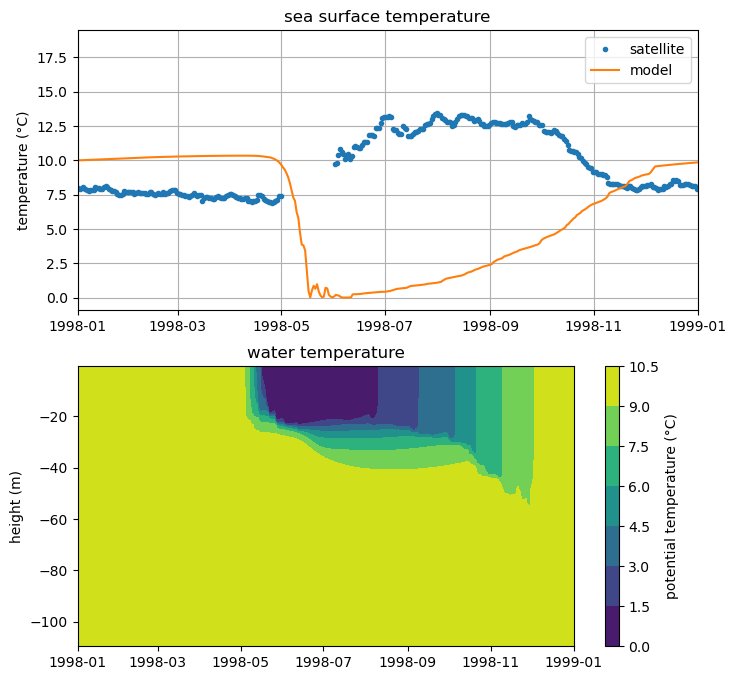

In [24]:
nc = netCDF4.Dataset(os.path.join(setup_dir, 'result.nc'))

time = netCDF4.num2date(nc['time'], nc['time'].units)
mpltime = dates.date2num(time)
z = nc['z'][:, :, 0, 0]
temp = nc[varname][:, :, 0, 0]
sst = temp[:, -1]

fig, (ax1, ax2) = pyplot.subplots(figsize=(8,8), nrows=2)

ax1.plot_date(obs[:,0], obs[:,1], '.', label='satellite')
ax1.plot_date(mpltime, sst, '-', label='model')
ax1.set_xlim(mpltime[0], mpltime[-1])
ax1.set_ylabel('temperature (\u00b0C)')
ax1.grid()
ax1.legend()
ax1.set_title('sea surface temperature')

mpltime_2d = np.broadcast_to(mpltime[:, np.newaxis], z.shape)
pc = ax2.contourf(mpltime_2d, z, temp)
cb = fig.colorbar(pc, ax=ax2)
cb.set_label('potential temperature (\u00b0C)')
ax2.set_ylabel('height (m)')
ax2.set_title('water temperature')
ax2.xaxis.axis_date()

## Plot ensemble GOTM results

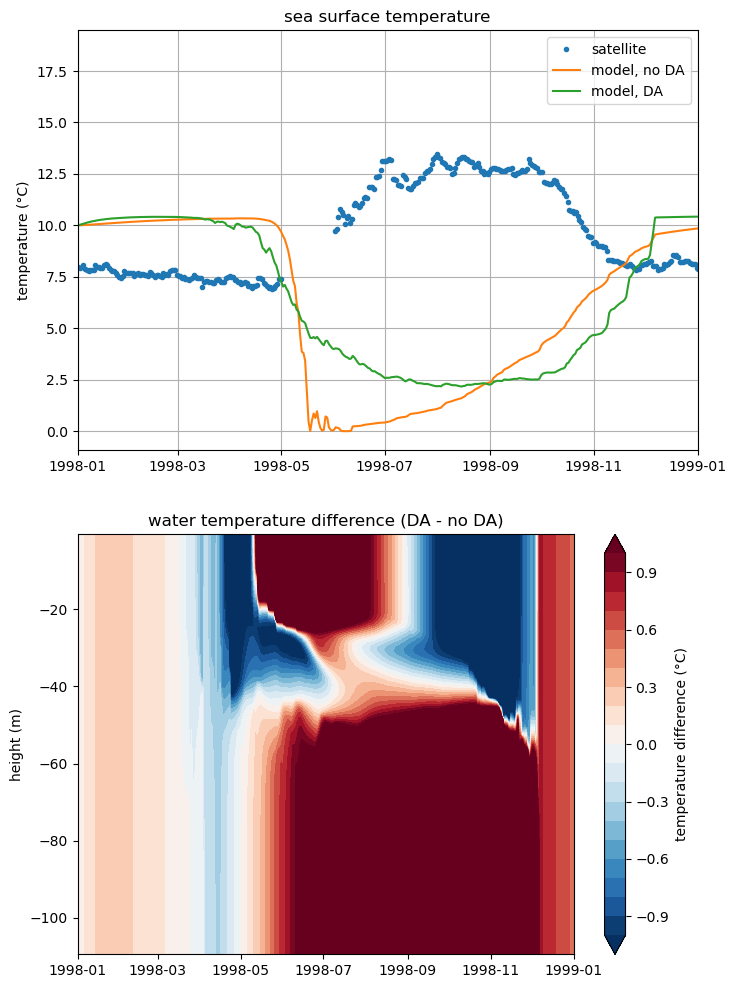

In [145]:
ncs = [netCDF4.Dataset(os.path.join(setup_dir, 'result_%04i.nc' % (i + 1))) for i in range(N)]

enstime = netCDF4.num2date(ncs[0]['time'], ncs[0]['time'].units)
ensmpltime = dates.date2num(enstime)
z = ncs[0].variables['z'][:, :, 0, 0]
temps = [nc[varname][:, :, 0, 0] for nc in ncs]
ssts = [temp[:, -1] for temp in temps]

fig, (ax1, ax2) = pyplot.subplots(figsize=(8,12), nrows=2)
ax1.plot_date(obs[:,0], obs[:,1], '.', label='satellite')
ax1.plot_date(time, sst, '-', label='model, no DA')
ax1.plot_date(enstime, np.mean(ssts, axis=0), '-', label='model, DA')
ax1.set_xlim(time[0], time[-1])
ax1.set_ylabel('temperature (\u00b0C)')
ax1.grid()
ax1.legend()
ax1.set_title('sea surface temperature')

mpltime_2d = np.broadcast_to(ensmpltime[:, np.newaxis], z.shape)
temp_diff = np.mean(temps, axis=0) - temp[-enstime.size:, :]
pc = ax2.contourf(mpltime_2d, z, temp_diff, cmap='RdBu_r', levels=np.linspace(-1.,1.,21), extend='both')
cb = fig.colorbar(pc, ax=ax2)
cb.set_label('temperature difference (\u00b0C)')
ax2.set_ylabel('height (m)')
ax2.set_title('water temperature difference (DA - no DA)');
ax2.xaxis.axis_date()

In [146]:
ncs = [netCDF4.Dataset(os.path.join(setup_dir, 'result_%04i.nc' % (i + 1))) for i in range(N)]

enstime = netCDF4.num2date(ncs[0]['time'], ncs[0]['time'].units)
ensmpltime = dates.date2num(enstime)
z = ncs[0].variables['z'][:, :, 0, 0]
temps = [nc[varname][:, :, 0, 0] for nc in ncs]
ssts = [temp[:, -1] for temp in temps]
output = np.mean(ssts,1)

In [4]:
df = pd.read_csv('parameter-values-300.csv',header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.037,0.013,0.13,0.12,2.7,2.4,2.1,2.5,0.093,0.18,...,0.09,0.19,2.4,0.28,0.597,0.012,0.079,0.78,4.1,0.83
1,0.030,0.015,0.13,0.21,4.6,1.5,2.8,3.1,0.098,0.17,...,0.09,0.28,1.4,0.33,0.237,0.061,0.642,0.82,1.0,0.55
2,0.038,0.011,0.11,0.29,3.5,2.9,2.1,1.5,0.088,0.02,...,0.18,0.14,2.8,0.15,0.384,0.054,0.124,1.16,2.5,1.19
3,0.022,0.010,0.11,0.19,4.7,2.5,2.6,4.7,0.126,0.18,...,0.29,0.32,2.6,0.27,0.508,0.082,0.380,0.11,5.0,0.18
4,0.014,0.015,0.11,0.31,4.6,3.3,1.7,1.7,0.089,0.13,...,0.18,0.19,3.3,0.04,0.165,0.096,0.285,0.78,7.0,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.029,0.009,0.13,0.49,0.6,2.5,2.5,2.0,0.099,0.21,...,0.17,0.07,2.7,0.17,0.207,0.074,0.510,0.42,3.4,1.41
296,0.041,0.010,0.09,0.35,3.7,1.9,2.2,4.2,0.113,0.05,...,0.02,0.13,3.1,0.14,0.253,0.057,0.923,1.07,8.8,0.60
297,0.029,0.013,0.14,0.30,1.3,2.1,0.6,4.7,0.072,0.10,...,0.35,0.16,0.7,0.33,0.565,0.026,0.258,0.28,2.9,0.40
298,0.010,0.010,0.13,0.20,1.1,1.4,1.7,2.3,0.086,0.03,...,0.22,0.18,0.3,0.18,0.299,0.054,0.793,0.39,2.9,1.42


In [147]:
from scipy import stats

r_spearman = np.zeros_like(name_para)
r_pearson = np.zeros_like(name_para)
p_spearman = np.zeros_like(name_para)
p_pearson = np.zeros_like(name_para)
for i in range(len(name_para)):
    r_spearman[i],p_spearman[i] = stats.spearmanr(output,sample_scaled[:,i])
    r_pearson[i],p_pearson[i] = stats.pearsonr(output,sample_scaled[:,i])
r_spearman = r_spearman.astype(float)
p_spearman = p_spearman.astype(float)
r_pearson = r_pearson.astype(float)
p_pearson = p_pearson.astype(float)

c_spearman = []
c_pearson = []
lws_spearman = []
lws_pearson = []
for i in range(len(name_para)):
    if r_spearman[i] < 0:
        c_spearman.append('tab:blue')
    elif r_spearman[i] > 0:
        c_spearman.append('tab:red')
    else:
        c_spearman.append('tab:gray') # rare case (r = 0)
    if p_spearman[i] < 0.05:
        lws_spearman.append(1.5)
    elif p_spearman[i] > 0.05:
        lws_spearman.append(0.5)
    else:
        lws_spearman.append(5) # rare case 
            
for i in range(len(name_para)):
    if r_pearson[i] < 0:
        c_pearson.append('tab:blue')
    elif r_pearson[i] > 0:
        c_pearson.append('tab:red')
    else:
        c_pearson.append('tab:gray') # rare case (r = 0)
    if p_pearson[i] < 0.05:
        lws_pearson.append(1.5)
    elif p_pearson[i] > 0.05:
        lws_pearson.append(0.5)
    else:
        lws_pearson.append(5) # rare case (p = 0.05)

In [148]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(sample_scaled, output)
importances = rf.feature_importances_

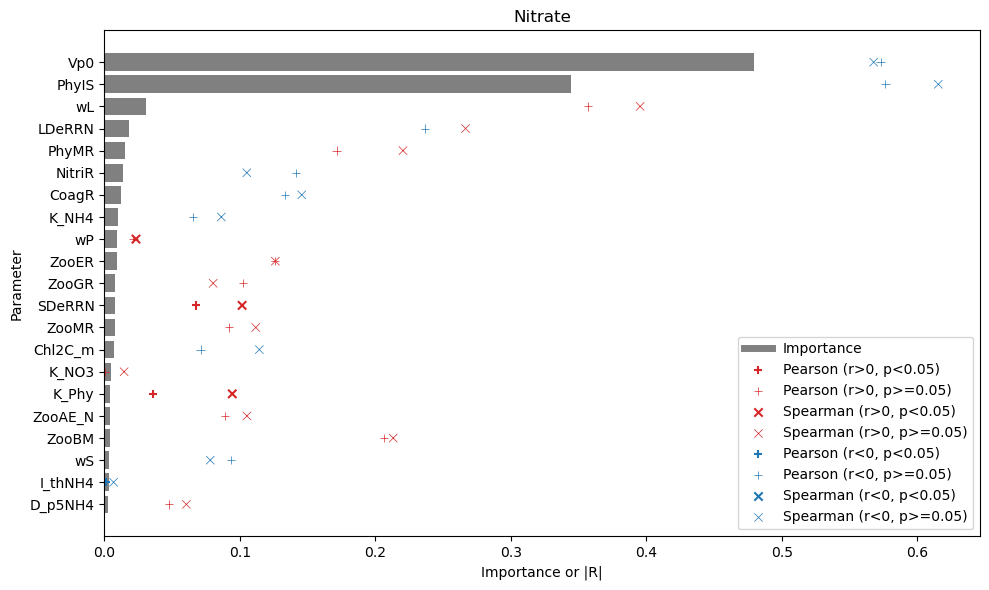

In [152]:
df = pd.DataFrame({
    "Parameter": name_para,
    "Importance": importances,
    "absR-Pearson":np.abs(r_pearson),
    "absR-Spearman":np.abs(r_spearman),
}).sort_values(by="Importance", ascending=False)

fig,ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df, x="Importance", y="Parameter",color='gray')
sns.scatterplot(data=df, x="absR-Pearson", y="Parameter",color=c_pearson,marker='+',linewidths=lws_pearson)
sns.scatterplot(data=df, x="absR-Spearman", y="Parameter",color=c_spearman,marker='x',linewidths=lws_spearman)
plt.title("Nitrate")
plt.xlabel('Importance or |R|')
plt.plot([],[],lw=5,color='gray',label='Importance')
plt.scatter([],[],color='tab:red',marker='+',linewidths=1.5,label='Pearson (r>0, p<0.05)')
plt.scatter([],[],color='tab:red',marker='+',linewidths=0.5,label='Pearson (r>0, p>0.05)')
plt.scatter([],[],color='tab:red',marker='x',linewidths=1.5,label='Spearman (r>0, p<0.05)')
plt.scatter([],[],color='tab:red',marker='x',linewidths=0.5,label='Spearman (r>0, p>0.05)')
plt.scatter([],[],color='tab:blue',marker='+',linewidths=1.5,label='Pearson (r<0, p<0.05)')
plt.scatter([],[],color='tab:blue',marker='+',linewidths=0.5,label='Pearson (r<0, p>0.05)')
plt.scatter([],[],color='tab:blue',marker='x',linewidths=1.5,label='Spearman (r<0, p<0.05)')
plt.scatter([],[],color='tab:blue',marker='x',linewidths=0.5,label='Spearman (r<0, p>0.05)')
plt.legend()
#ax.set_xlim(0, 1)
plt.tight_layout()
#plt.show()
plt.savefig('fig-sensitivity-'+varname+'-'+str(N),dpi=300,bbox_inches='tight')